## Task-1 - Convolutional Neural Networks for Image Classification
In this task you will be training a simple CNN model to perform a binary classification on cats and dogs. You will be provided with a dataset

For submission , upload the following :
1. model summary by calling model.summary()
2. The train vs val loss and accuracy plots
3. The confusion matrix
4. The classification report on test dataset

### Install Dependencies
Install torchinfo for model summary visualization.


In [1]:
%pip install torchinfo --quiet

### Import Libraries
Import all necessary PyTorch libraries, data handling tools, and visualization packages.


In [2]:
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchinfo import summary

torch.backends.cudnn.benchmark = True


### Define CNN Architecture
Define the SimpleCNN model with residual blocks for cats vs dogs classification.


In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return F.relu(out + x)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2, p_drop=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            ResidualBlock(128),
            nn.Conv2d(128, 256, 3, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            ResidualBlock(256),
            nn.Conv2d(256, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            ResidualBlock(512),
            nn.Conv2d(512, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(inplace=True), nn.MaxPool2d(2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p_drop)
        self.fc = nn.Linear(512, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01); nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(self.avgpool(x), 1)
        x = self.dropout(x)
        return self.fc(x)

model = SimpleCNN(num_classes=2)
print(model)
summary(model, input_size=(1, 3, 224, 224))

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ResidualBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runn

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 2]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,728
│    └─BatchNorm2d: 2-2                  [1, 64, 224, 224]         128
│    └─ReLU: 2-3                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-4                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-5                       [1, 128, 112, 112]        73,728
│    └─BatchNorm2d: 2-6                  [1, 128, 112, 112]        256
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-8                    [1, 128, 56, 56]          --
│    └─ResidualBlock: 2-9                [1, 128, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 128, 56, 56]          147,456
│    │    └─BatchNorm2d: 3-2             [1, 128, 56, 56]          256


### Load and Prepare Dataset
Load cats vs dogs dataset and create train/test splits with data augmentation.


In [4]:
ds = load_dataset("pantelism/cats-vs-dogs")

train_test_split = ds['train'].train_test_split(test_size=0.2, seed=42)
train_ds = train_test_split['train']
test_ds = train_test_split['test']

class CustomDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']

        if self.transform:
            image = self.transform(image)

        return image, label

train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(train_ds, transform=train_tf)
test_dataset = CustomDataset(test_ds, transform=test_tf)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dogs-vs-cats-subset.zip:   0%|          | 0.00/90.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4000 [00:00<?, ? examples/s]

### Train the Model
Train the CNN model and track training/validation loss and accuracy.


In [5]:

num_epochs = 20
learning_rate = 0.0005
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss /= len(test_loader)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

print('Finished Training')

Epoch [1/20], Train Loss: 0.6464, Train Acc: 62.66%, Val Loss: 0.6321, Val Acc: 64.38%
Epoch [2/20], Train Loss: 0.5918, Train Acc: 68.16%, Val Loss: 0.6320, Val Acc: 63.50%
Epoch [3/20], Train Loss: 0.5684, Train Acc: 70.34%, Val Loss: 0.5648, Val Acc: 70.62%
Epoch [4/20], Train Loss: 0.5452, Train Acc: 73.44%, Val Loss: 0.5772, Val Acc: 69.00%
Epoch [5/20], Train Loss: 0.5088, Train Acc: 74.97%, Val Loss: 0.5981, Val Acc: 73.12%
Epoch [6/20], Train Loss: 0.4690, Train Acc: 78.09%, Val Loss: 0.4914, Val Acc: 76.00%
Epoch [7/20], Train Loss: 0.4335, Train Acc: 80.75%, Val Loss: 0.5358, Val Acc: 75.00%
Epoch [8/20], Train Loss: 0.4223, Train Acc: 81.00%, Val Loss: 0.4487, Val Acc: 79.38%
Epoch [9/20], Train Loss: 0.4072, Train Acc: 80.97%, Val Loss: 0.4335, Val Acc: 81.12%
Epoch [10/20], Train Loss: 0.3737, Train Acc: 83.56%, Val Loss: 0.3998, Val Acc: 83.00%
Epoch [11/20], Train Loss: 0.3319, Train Acc: 85.75%, Val Loss: 0.4713, Val Acc: 80.00%
Epoch [12/20], Train Loss: 0.3325, Train 

### Plot Training History
Visualize training and validation loss and accuracy over epochs.


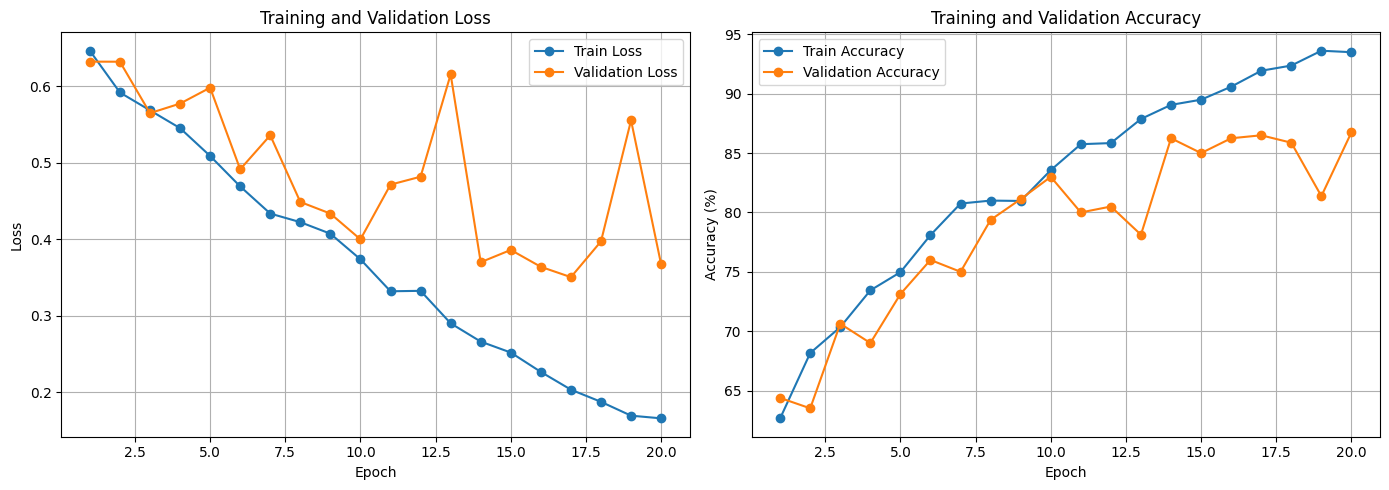

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_completed = len(train_losses)
epochs_range = range(1, epochs_completed + 1)

ax1.plot(epochs_range, train_losses, label='Train Loss', marker='o')
ax1.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o')
ax2.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### Evaluate on Test Set
Generate confusion matrix and classification report for test dataset.


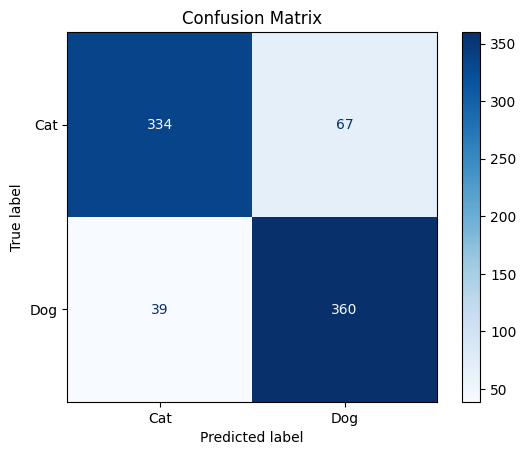


Confusion Matrix:
[[334  67]
 [ 39 360]]

Classification Report:
              precision    recall  f1-score   support

         Cat       0.90      0.83      0.86       401
         Dog       0.84      0.90      0.87       399

    accuracy                           0.87       800
   macro avg       0.87      0.87      0.87       800
weighted avg       0.87      0.87      0.87       800



In [7]:
model.eval()

all_predictions = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

cm = confusion_matrix(all_targets, all_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(all_targets, all_predictions, target_names=['Cat', 'Dog']))

### Save Model
Save the trained model weights.


In [8]:
model_save_path = 'cnn_weights.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to cnn_weights.pth
